In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

/scratch/gpfs/WBIALEK/ls1546/.conda/envs/gpt-circuits/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allenai/OLMo-2-0425-1B', device_map='auto')
tokenizer.pad_token = tokenizer.eos_token

In [76]:
data_idx = 1
run_type = ['bbc', 'c4', 'poetry'][data_idx]  # change index to select different dataset
descriptions = {
"simple" : "Simple English Wikipedia",
"wiki" : "English Wikipedia",
"bbc" : "BBC News Articles",
"c4": "C4 Internet Corpus",
"BooksumText": "CliffNotes Chapter Summaries",
"BooksumAnalysis": "CliffNotes Chapter Analyses",
"BookChapter": "CliffNotes Book Chapters",
"gpc": "Gutenberg Poetry Collection",
"poetry": "Poetry Foundation Poems",
}

In [77]:
# load entropies, predicted tokens, attention masks
entropies = np.load(f'token_entropies_{run_type}.npy')
predicted_tokens = np.load(f'predicted_tokens_{run_type}.npy')
attention_masks = np.load(f'attention_masks_{run_type}.npy')

In [78]:
print(entropies.shape, predicted_tokens.shape, attention_masks.shape)

(2000, 2000) (2000, 2000) (2000, 2000)


sum of all histogram bins at token position 1: 0.9999999999999999
sum of all histogram bins at token position 3: 1.0000000000842095
sum of all histogram bins at token position 40: 1.000000001021406
sum of all histogram bins at token position 100: 0.9999999986186129
sum of all histogram bins at token position 1000: 1.0000000008667989
sum of all histogram bins at token position 1999: 0.9999999973027399


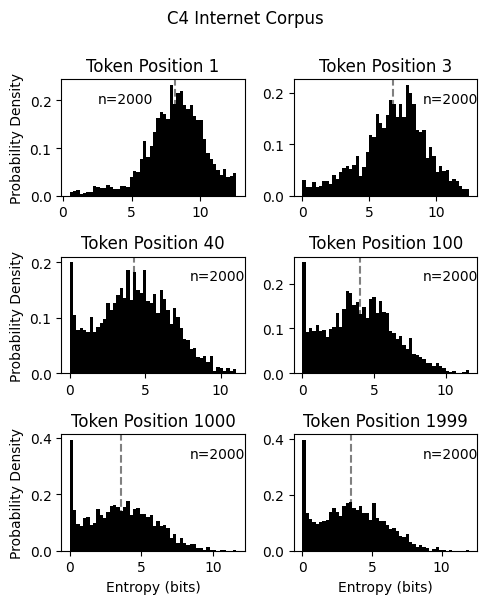

In [79]:
# plot histograms of entropies
# subplots where each subplot is a histogram of entropies for a specific token position (1, 3, 40, 100, 1000, 2000)
positions = [1, 3, 40, 100, 1000, 1999]
fig, axs = plt.subplots(len(positions)//2, 2, figsize=(5, 6), sharex=False, sharey=False)
axs = axs.flatten()
for i, pos in enumerate(positions):
    samples = np.sum(attention_masks[:, pos] == 1)
    # print('number of valid tokens at position', pos, ':', samples)
    counts, bins, _ = axs[i].hist(entropies[attention_masks[:, pos] == 1, pos], density=True, bins=50, color='black')
    print(f"sum of all histogram bins at token position {pos}:", np.sum(counts * np.diff(bins)))

    axs[i].axvline(np.mean(entropies[attention_masks[:, pos] == 1, pos]), c='gray', zorder=-1, ls='--')
    axs[i].set_title(f'Token Position {pos}')
    # add an annotation with the number of valid tokens at this position
    if i == 0:
        xy = (0.2, 0.8)
    else:
        xy = (0.7, 0.8)
    axs[i].annotate(f'n={samples}', xy=xy, xycoords='axes fraction')
for i in range(0, len(positions), 2):
    axs[i].set_ylabel('Probability Density')

for i in range(len(positions) - 2, len(positions)):
    axs[i].set_xlabel('Entropy (bits)')
plt.suptitle(f'{descriptions[run_type]}', y=1.0)
plt.tight_layout()
plt.savefig(f'entropy_histograms_{run_type}.png')

In [65]:
counts, bins

(array([0.61853326, 0.17672379, 0.26508568, 0.        , 0.08836189,
        0.        , 0.        , 0.        , 0.        , 0.17672385,
        0.        , 0.0883618 , 0.08836186, 0.26508634, 0.        ,
        0.17672373, 0.44180931, 0.17672373, 0.35344745, 0.17672373,
        0.08836186, 0.17672422, 0.17672373, 0.        , 0.17672373,
        0.17672373, 0.08836186, 0.17672422, 0.17672373, 0.53017118,
        0.08836186, 0.08836186, 0.08836186, 0.08836186, 0.        ,
        0.17672373, 0.        , 0.08836186, 0.08836186, 0.08836186,
        0.        , 0.        , 0.        , 0.08836211, 0.        ,
        0.08836186, 0.        , 0.        , 0.        , 0.08836186]),
 array([8.04197788e-03, 1.76953852e-01, 3.45865726e-01, 5.14777601e-01,
        6.83689475e-01, 8.52601349e-01, 1.02151322e+00, 1.19042504e+00,
        1.35933697e+00, 1.52824891e+00, 1.69716072e+00, 1.86607254e+00,
        2.03498459e+00, 2.20389652e+00, 2.37280798e+00, 2.54171991e+00,
        2.71063185e+00, 2.8795

In [ ]:

# for these context lengths, find the tokens with zero entropy and print their text and counts, find the unique tokens and their counts

token_counts = {}
for i in range(entropies.shape[0]):
    for j in range(entropies.shape[1]):
        if attention_masks[i, j] == 1 and entropies[i, j] < 0.01:
            token_id = predicted_tokens[i, j]
            token_text = tokenizer.decode(token_id, clean_up_tokenization_spaces=False)
            if token_text in token_counts:
                token_counts[token_text] += 1
            else:
                token_counts[token_text] = 1

# for token_text, count in token_counts.items():
#     print(f'Token Text: "{token_text}", Count: {count}')
# sort by count descending
sorted_token_counts = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
for token_text, count in sorted_token_counts:
    print(f'Token Text: "{token_text}", Count: {count}')

# print tokes with 0 entropy grouped by position
# make bins where each bin is a list of tokens with 0 entropy at that position or earlier
zero_entropy_bins = {}
for i in range(entropies.shape[0]):
    for j in range(entropies.shape[1]):
        if attention_masks[i, j] == 1 and entropies[i, j] < 0.01:
            token_id = predicted_tokens[i, j]
            token_text = tokenizer.decode(token_id, clean_up_tokenization_spaces=False)
            if j not in zero_entropy_bins:
                zero_entropy_bins[j] = set()
            zero_entropy_bins[j].add(token_text)

# print the tokens with zero entropy at positions 1, 3, 40, 100, 1000, 1250
for pos in [1, 3, 40, 100, 1000, 1250]:
    tokens_at_pos = set()
    for i in range(1, pos):
        tokens_at_pos.update(zero_entropy_bins.get(i, set()))
    print(f'Position {pos}:')
    print(f'Token Text: {tokens_at_pos}')

# look at the highest entropy tokens at each of these positions
for pos in [1, 3, 40, 100, 1000, 1250]:
    entropies_at_pos = []
    token_texts_at_pos = []
    for i in range(entropies.shape[0]):
        if attention_masks[i, pos-1] == 1:
            entropies_at_pos.append(entropies[i, pos-1])
            token_id = predicted_tokens[i, pos-1]
            token_text = tokenizer.decode(token_id, clean_up_tokenization_spaces=False)
            token_texts_at_pos.append(token_text)
    # get indices of top 5 highest entropy tokens
    top_indices = np.argsort(entropies_at_pos)[-5:]
    print(f'Position {pos}:')
    for idx in top_indices:
        print(f'Token Text: "{token_texts_at_pos[idx]}", Entropy: {entropies_at_pos[idx]}')